In [1]:
import sympy
from sympy.plotting import plot
import sympy as sp
import penbegone as pbg
from penbegone import common as bgcom
from penbegone import plotting as bgplot
from penbegone.common import printeq

%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

## System definition

In [2]:
t = sp.symbols("t")
v = bgcom.functions("v", t)
g = sp.symbols("g", positive=True)
h = bgcom.functions("h", t)

pitch, throttle, m = sp.symbols("theta delta_t m")
F_t, c_drag, S, rho = sp.symbols("F_t C_drag S rho")
theta_0 = sp.symbols("theta_0")
drag_ = 0.5*S*rho*v*v*c_drag
f_v_dot_ = 1/m*(sp.sin(pitch)*g + F_t*throttle - drag_)
f_h_dot_ = v*sp.sin(pitch-theta_0)  # Perhaps add effect of increasing lift as airspeed increases?

In [3]:
num_values = dict()

In [4]:
plant = [f_v_dot_, f_h_dot_]
plant_states = [v, h]

# These are the translated states around the trim point.
v_star, h_star = sp.symbols("v_star h_star")
plant_states_translated = [v_star, h_star]

## Controller

In [5]:
h_dem, h_dem_dot, v_dem, v_dem_dot = sp.symbols("h_d h_d_dot v_d v_d_dot")
v_c = sp.symbols("v_cruise")
h_dot = sp.diff(h, t)
v_dot = sp.diff(v, t)
v_max, v_min, climb_max, sink_max, sink_min = sp.symbols("V_max V_min hdot_cmax hdot_smax hdot_smin")
thr_max, thr_min, thr_trim = sp.symbols("thr_{max} thr_{min} thr_{trim}")
w, k_tc, k_pd, k_i, k_td = sp.symbols("w k_tc k_pd k_i k_td", real=True)

In [6]:
STEdot_max, STEdot_min, STEdot_neg_max = sp.symbols("Edot^*_max Edot^*_min Edot^*_nmax")

STEdot_max_ = g*climb_max
STEdot_min_ = -g*sink_min
STEdot_neg_max = -g*sink_max

In [7]:
## _update_speed_demand

# Perhaps the increase of _TAS_dem when at max sink plays a role?

vel_rate_max_ = 0.5*STEdot_max_/v
vel_rate_neg_cruise = 0.9*STEdot_min_/v_c
vel_rate_neg_max = 0.9*STEdot_min_/v_max

# I can add the LPF effect of TIME_CONST here, instead of pure differentiation.
controller_states = [v_dem]

In [8]:
## _update_height_demand

# Can add the LPF effect of HDEM_TCONST here, over h_dem.
controller_states.append(h_dem)

In [9]:
## _update_energies

SPE_dem_ = h_dem*g
SKE_dem_ = 0.5*v_dem*v_dem
SKE_est_ = 0.5*v*v
SKE_dot_dem_= v*v_dem_dot # In the source vdot_dem_ is high-passed. How does this translate to the actual system?
SKE_dot_ = v*v_dot # Same comment as above.
SPE_est_ = h*g
SPE_dot_ = h_dot*g

In [10]:
## _update_pitch

w_k_ = w
w_p_ = 2-w

SEB_dem_ = SPE_dem_*w_p_ - SKE_dem_*w_k_
SEB_est_ = SPE_est_*w_p_ - SKE_est_*w_k_
SEB_err_ = SEB_dem_ - SEB_est_
SEB_dot_est_ = SPE_dot_*w_p_ - SKE_dot_*w_k_

SEB_dot_dem_ = SEB_err_/k_tc + h_dem_dot*g*w_p_
SEB_dot_err_ = SEB_dot_dem_ - SEB_dot_est_
SEB_dot_dem_tot_ = SEB_dot_dem_ + SEB_dot_err_*k_pd

# Adding integrator states.
SEB_dot_int = sp.symbols("x_{intsebdot}")
controller_states.append(SEB_dot_int)
SEB_dot_int_dot_ = SEB_dot_err_*k_i

KE_int = sp.symbols("x_{intKE}")
controller_states.append(KE_int)
KE_int_dot_ = (SKE_est_ - SKE_dem_)*w_k_/k_tc

pitch_dem_ = (SEB_dot_dem_tot_ + SEB_dot_int + KE_int) / (v * g)

In [11]:
## _update_throttle_with_airspeed

STE_error_ = SKE_dem_ - SKE_est_ + SPE_dem_ - SPE_est_
SPE_dot_dem_ = (SPE_dem_ - SPE_est_)/k_tc
STE_dot_dem_ = SPE_dot_dem_ + SKE_dot_dem_
STE_dot_err_ = STE_dot_dem_ - SKE_dot_ - SPE_dot_

K_thr2STE_ = (STEdot_max_ - STEdot_min_)/(thr_max - thr_min)
K_STE2Thr_ = 1 / (K_thr2STE_ * k_tc)
# Adding integrator state.
integTHR_state = sp.symbols("x_{intthr}")
controller_states.append(integTHR_state)
integTHR_state_dot_ = STE_error_*k_i*K_STE2Thr_
ff_throttle = STE_dot_dem_/K_thr2STE_ + thr_trim

throttle_dem_ = K_STE2Thr_*(STE_error_ + STE_dot_err_*k_td) + ff_throttle + integTHR_state

In [12]:
controller = {throttle: throttle_dem_, pitch: pitch_dem_}
controller_states_derivatives = [v_dem_dot, h_dem_dot, SEB_dot_int_dot_, KE_int_dot_, integTHR_state_dot_]

for c in controller.values():
    display(c.simplify())

(g*k_tc**2*(hdot_cmax + hdot_smin)*(thr_{trim} + x_{intthr}) + k_tc*(thr_{max} - thr_{min})*(g*h_d - g*h(t) + k_tc*v_d_dot*v(t)) - (thr_{max} - thr_{min})*(k_tc*(-g*h_d + g*h(t) - 0.5*v_d**2 + 0.5*v(t)**2) + k_td*(-g*h_d + g*h(t) + k_tc*(g*Derivative(h(t), t) - v_d_dot*v(t) + v(t)*Derivative(v(t), t)))))/(g*k_tc**2*(hdot_cmax + hdot_smin))

(-g*h_d*(w - 2) + g*(w - 2)*h(t) + k_pd*(-g*h_d*(w - 2) + g*(w - 2)*h(t) + k_tc*(-g*h_d_dot*(w - 2) + g*(w - 2)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t)) - 0.5*v_d**2*w + 0.5*w*v(t)**2) + k_tc*(-g*h_d_dot*(w - 2) + x_{intKE} + x_{intsebdot}) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/(g*k_tc*v(t))

## Autonomous system

In [13]:
num_values[thr_max] = 1
num_values[thr_min] = 0
num_values[h_dem_dot] = 0
num_values[v_dem_dot] = 0
plant = [s.subs(num_values) for s in plant]

In [14]:
system_states = plant_states + controller_states
system = plant + controller_states_derivatives

In [15]:
system = [s_i.subs(controller | num_values) for s_i in system]
for k, s in zip(system_states, system):
    printeq(k, s)

Eq(v(t), (-0.5*C_drag*S*rho*v(t)**2 + F_t*(thr_{trim} + x_{intthr} + (g*h_d - g*h(t))/(k_tc*(g*hdot_cmax + g*hdot_smin)) + (g*h_d - g*h(t) + k_td*(-g*Derivative(h(t), t) - v(t)*Derivative(v(t), t) + (g*h_d - g*h(t))/k_tc) + 0.5*v_d**2 - 0.5*v(t)**2)/(k_tc*(g*hdot_cmax + g*hdot_smin))) + g*sin((g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc) + x_{intKE} + x_{intsebdot} + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc)/(g*v(t))))/m)

Eq(h(t), -v(t)*sin(theta_0 - (g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc) + x_{intKE} + x_{intsebdot} + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc)/(g*v(t))))

Eq(v_d, 0)

Eq(h_d, 0)

Eq(x_{intsebdot}, k_i*(-g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc))

Eq(x_{intKE}, w*(-0.5*v_d**2 + 0.5*v(t)**2)/k_tc)

Eq(x_{intthr}, k_i*(g*h_d - g*h(t) + 0.5*v_d**2 - 0.5*v(t)**2)/(k_tc*(g*hdot_cmax + g*hdot_smin)))

In [16]:
del system[2]
del system[2]
del system_states[2]
del system_states[2]
for k, s in zip(system_states, system):
    printeq(k, s)

Eq(v(t), (-0.5*C_drag*S*rho*v(t)**2 + F_t*(thr_{trim} + x_{intthr} + (g*h_d - g*h(t))/(k_tc*(g*hdot_cmax + g*hdot_smin)) + (g*h_d - g*h(t) + k_td*(-g*Derivative(h(t), t) - v(t)*Derivative(v(t), t) + (g*h_d - g*h(t))/k_tc) + 0.5*v_d**2 - 0.5*v(t)**2)/(k_tc*(g*hdot_cmax + g*hdot_smin))) + g*sin((g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc) + x_{intKE} + x_{intsebdot} + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc)/(g*v(t))))/m)

Eq(h(t), -v(t)*sin(theta_0 - (g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc) + x_{intKE} + x_{intsebdot} + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc)/(g*v(t))))

Eq(x_{intsebdot}, k_i*(-g*(2 - w)*Derivative(h(t), t) + w*v(t)*Derivative(v(t), t) + (g*h_d*(2 - w) - g*(2 - w)*h(t) - 0.5*v_d**2*w + 0.5*w*v(t)**2)/k_tc))

Eq(x_{intKE}, w*(-0.5*v_d**2 + 0.5*v(t)**2)/k_tc)

Eq(x_{intthr}, k_i*(g*h_d - g*h(t) + 0.5*v_d**2 - 0.5*v(t)**2)/(k_tc*(g*hdot_cmax + g*hdot_smin)))

Trying to simplify this takes more than 1min.

## Equilibrium points

In [17]:
num_values[g] = 9.81
num_values[rho] = 1.225

num_values[v_dot] = 0
num_values[h_dot] = 0
# num_values[h] = h_dem

var_rep = dict()
x_ipitch = sp.symbols("x_{ipitch}")
var_rep[SEB_dot_int + KE_int] = x_ipitch
system_2 = [s.subs(var_rep) for s in system]
system_2_states = [s for s in system_states]

del system_2[2]
del system_2[2]
system_2.append(SEB_dot_int_dot_ + KE_int_dot_)
del system_2_states[2]
del system_2_states[2]
system_2_states.append(x_ipitch)
x_intthrstar = sp.symbols("x_{intthr*}")
x_ipitchstar = sp.symbols("x_{ipitch*}")
system_2_states_translated = [v_star, h_star, x_intthrstar, x_ipitchstar]

system_2 = [s.subs(num_values) for s in system_2]

In [18]:
for k, s in zip(system_2_states, system_2):
    printeq(k, s.n(2))

Eq(v(t), (-0.61*C_drag*S*v(t)**2 + F_t*(thr_{trim} + x_{intthr} + (9.8*h_d - 9.8*h(t))/(k_tc*(9.8*hdot_cmax + 9.8*hdot_smin)) + (9.8*h_d + 0.5*v_d**2 - 9.8*h(t) - 0.5*v(t)**2 + k_td*(9.8*h_d - 9.8*h(t))/k_tc)/(k_tc*(9.8*hdot_cmax + 9.8*hdot_smin))) + 9.8*sin(0.101936799184506*(k_pd*(9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*v(t)**2 - 9.81*(2 - w)*h(t))/k_tc + x_{ipitch} + (9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*v(t)**2 - 9.81*(2 - w)*h(t))/k_tc)/v(t)))/m)

Eq(h(t), -v(t)*sin(theta_0 - 0.101936799184506*(k_pd*(9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*v(t)**2 - 9.81*(2 - w)*h(t))/k_tc + x_{ipitch} + (9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*v(t)**2 - 9.81*(2 - w)*h(t))/k_tc)/v(t)))

Eq(x_{intthr}, k_i*(9.8*h_d + 0.5*v_d**2 - 9.8*h(t) - 0.5*v(t)**2)/(k_tc*(9.8*hdot_cmax + 9.8*hdot_smin)))

Eq(x_{ipitch}, k_i*(9.8*h_d*(2.0 - w) - 0.5*v_d**2*w + 0.5*w*v(t)**2 - 9.8*(2.0 - w)*h(t))/k_tc + w*(-0.5*v_d**2 + 0.5*v(t)**2)/k_tc)

In [19]:
# e_points = sp.solve(Sys_a, states_a, dict=True)
# Sys_am = [s for i, s in enumerate(Sys_a) if i in [0, 1, 4, 5] ]
# states_am = [s for i, s in enumerate(states_a) if i in [0, 1, 4, 5] ]
e_points = sp.solve(system_2, system_2_states, dict=True)
e_points

[{x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} - 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: -9.81*theta_0*v_d,
  h(t): h_d,
  v(t): -v_d},
 {x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} - 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*theta_0*v_d,
  h(t): h_d,
  v(t): v_d},
 {x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} + 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*v_d*(3.14159265358979 - theta_0),
  h(t): h_d,
  v(t): -v_d},
 {x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} + 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*v_d*(theta_0 - 3.14159265358979),
  h(t): h_d,
  v(t): v_d}]

In [20]:
sol_idx = 1
# states_trim = {k: x.simplify() for k, x in e_points[sol_idx].items()}  # Ignoring the other solutions.
states_trim = {s: e_points[sol_idx][s] for s in system_2_states}
for k, s in states_trim.items():
    printeq(k, s)

Eq(v(t), v_d)

Eq(h(t), h_d)

Eq(x_{intthr}, 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} - 3924.0*sin(theta_0))/F_t)

Eq(x_{ipitch}, 9.81*theta_0*v_d)

## Translated system

In [21]:
trans_dict = dict()
for i, st in enumerate(system_2_states):
    trans_dict[system_2_states[i]] = system_2_states_translated[i] + states_trim[st]
system_2_translated = [s_i.subs(trans_dict) for s_i in system_2]
for k, s in zip(system_2_states_translated, system_2_translated):
    printeq(k, s)

Eq(v_star, (-0.6125*C_drag*S*(v_d + v_star)**2 + F_t*(-9.81*h_star/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + thr_{trim} + x_{intthr*} + (-9.81*h_star - 9.81*h_star*k_td/k_tc + 0.5*v_d**2 - 0.5*(v_d + v_star)**2)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*thr_{trim} - 3924.0*sin(theta_0))/F_t) + 9.81*sin(0.101936799184506*(k_pd*(9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*(v_d + v_star)**2 - 9.81*(2 - w)*(h_d + h_star))/k_tc + 9.81*theta_0*v_d + x_{ipitch*} + (9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*(v_d + v_star)**2 - 9.81*(2 - w)*(h_d + h_star))/k_tc)/(v_d + v_star)))/m)

Eq(h_star, -(v_d + v_star)*sin(theta_0 - 0.101936799184506*(k_pd*(9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*(v_d + v_star)**2 - 9.81*(2 - w)*(h_d + h_star))/k_tc + 9.81*theta_0*v_d + x_{ipitch*} + (9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*(v_d + v_star)**2 - 9.81*(2 - w)*(h_d + h_star))/k_tc)/(v_d + v_star)))

Eq(x_{intthr*}, k_i*(-9.81*h_star + 0.5*v_d**2 - 0.5*(v_d + v_star)**2)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)))

Eq(x_{ipitch*}, k_i*(9.81*h_d*(2 - w) - 0.5*v_d**2*w + 0.5*w*(v_d + v_star)**2 - 9.81*(2 - w)*(h_d + h_star))/k_tc + w*(-0.5*v_d**2 + 0.5*(v_d + v_star)**2)/k_tc)

## Linearization

In [22]:
A = sp.zeros(len(system_2_states_translated), len(system_2_states_translated))
zero_state = {st: 0 for st in system_2_states_translated}
for i, f in enumerate(system_2_translated):
    for j, x in enumerate(system_2_states_translated):
        A[i, j] = sp.diff(f, x).subs(zero_state).simplify()
display(A)

Matrix([
[-(1.225*C_drag*S*k_tc*v_d**2*(hdot_cmax + hdot_smin) + 0.101936799184506*F_t*v_d**2 + 9.81*(hdot_cmax + hdot_smin)*(1.0*k_tc*theta_0 - 0.101936799184506*v_d*w*(k_pd + 1))*cos(1.0*theta_0))/(k_tc*m*v_d*(hdot_cmax + hdot_smin)), 1.0*(-F_t*v_d*(2*k_tc + k_td) + k_tc*(hdot_cmax + hdot_smin)*(k_pd*(9.81*w - 19.62) + 9.81*w - 19.62)*cos(1.0*theta_0))/(k_tc**2*m*v_d*(hdot_cmax + hdot_smin)), F_t/m, 1.0*cos(1.0*theta_0)/(m*v_d)],
[                                                                                                                                                                    (-1.0*k_tc*theta_0 + 0.101936799184506*v_d*w*(k_pd + 1))/k_tc,                                                                                                    (0.101936799184506*k_pd*(9.81*w - 19.62) + 1.0*w - 2.0)/k_tc,     0,            0.101936799184506],
[                                                                                                                                        

In [23]:
num_values |= {
    climb_max: 5,
    sink_max: -10,
    sink_min: -2,
    w: 1,
    m: 25,
    v_dem: 20,
    h_dem: 0,
    F_t: 5,
    theta_0: 1*3.14/180,
    S: 0.8,
    c_drag: 0.3
}
A_num_ = A.subs(num_values)
display(A_num_.n(2))

controller_trimmed = [c for c in controller.values()]
controller_trimmed = [c.subs(trans_dict) for c in controller_trimmed]
controller_trimmed = [c.subs(states_trim) for c in controller_trimmed]
controller_trimmed = [c.subs(num_values) for c in controller_trimmed]
for c in controller_trimmed:
    display(c.n(2).doit().expand().collect([h_star, v_star]))

Matrix([
[-0.00067*(-60.0*k_pd + 3.5e+2*k_tc + 1.4e+2)/k_tc, 0.00067*(3.0*k_tc*(-9.8*k_pd - 9.8) - 2.0e+2*k_tc - 1.0e+2*k_td)/k_tc**2, 0.2, 0.002],
[               (2.0*k_pd - 0.017*k_tc + 2.0)/k_tc,                                                   (-1.0*k_pd - 1.0)/k_tc,   0,   0.1],
[                                   -0.68*k_i/k_tc,                                                           -0.33*k_i/k_tc,   0,     0],
[                            20.0*(k_i + 1.0)/k_tc,                                                            -9.8*k_i/k_tc,   0,     0]])

h_star*(-0.67/k_tc - 0.33*k_td/k_tc**2) + x_{intthr*} + 12.0 - 0.017*v_star**2/k_tc - 0.68*v_star/k_tc

h_star*(-1.0*k_pd/(k_tc*v_star + 20.0*k_tc) - 1.0/(k_tc*v_star + 20.0*k_tc)) + v_star**2*(0.051*k_pd/(k_tc*v_star + 20.0*k_tc) + 0.051/(k_tc*v_star + 20.0*k_tc)) + v_star*(2.0*k_pd/(k_tc*v_star + 20.0*k_tc) + 2.0/(k_tc*v_star + 20.0*k_tc)) + 0.1*x_{intKE}/(v_star + 20.0) + 0.1*x_{intsebdot}/(v_star + 20.0)

## Phase portrait

In [24]:
from sympy.utilities.autowrap import ufuncify
import numpy as np
import matplotlib.pyplot as plt

fixed_states = {
    x_ipitch : states_trim[x_ipitch],
    integTHR_state : states_trim[integTHR_state]
}
controller_gains = {
    k_pd: 0.3,
    k_i: 0.3,
    k_tc: 5,
    k_td: 0.5,
}
v_flat = sp.symbols("v_flat")
h_flat = sp.symbols("h_flat")
map_fun_to_var = {
    v: v_flat,
    h: h_flat
}
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2]
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2_flat]
# for s in system_2_flat:
#     display(s.n(2))

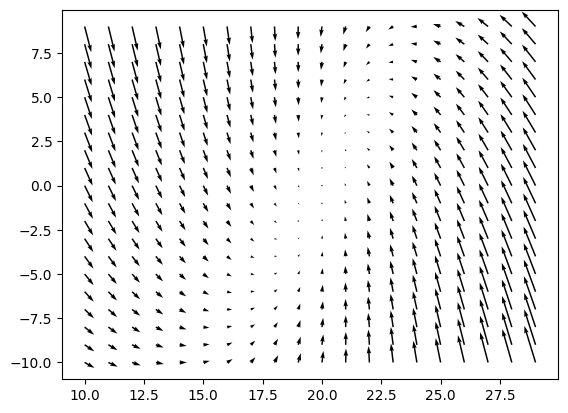

In [25]:
X, Y = np.meshgrid(np.arange(10,30,1), np.arange(-10,10,1))
uxy = ufuncify((v_flat, h_flat), system_2_flat[0])
vxy = ufuncify((v_flat, h_flat), system_2_flat[1])
plt.figure()
plt.quiver(X, Y, uxy(X, Y), vxy(X, Y))

## Lyapunov function

Since we assume that the origin is asymptotically stable, we choose a Lyapunov function of the form $V(x) = x^T P x$.

In [26]:
P_l = sp.diag(*[1]*len(system_2_states_translated))
display(P_l)
display(sp.Matrix([system_2_states_translated]))
V_l = (sp.Matrix([system_2_states_translated]) * P_l * sp.Matrix([system_2_states_translated]).T)[0,0]
display(V_l)

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

Matrix([[v_star, h_star, x_{intthr*}, x_{ipitch*}]])

h_star**2 + v_star**2 + x_{intthr*}**2 + x_{ipitch*}**2

In [27]:
fun_dict = dict()
t = sp.symbols("t", positive=True)
f_h, f_v, f_xintthr, f_xipitch = bgcom.functions("h v x_{intthr} x_{ipitch}", t)
functions_map = dict(zip([h_star, v_star, x_intthrstar, x_ipitchstar], [f_h, f_v, f_xintthr, f_xipitch]))
V_l_dot = V_l.subs(functions_map).diff(t)
display(V_l_dot)

2*h(t)*Derivative(h(t), t) + 2*v(t)*Derivative(v(t), t) + 2*x_{intthr}(t)*Derivative(x_{intthr}(t), t) + 2*x_{ipitch}(t)*Derivative(x_{ipitch}(t), t)

In [28]:
subs_dict = dict(zip([
    sp.diff(f_v,t),
    sp.diff(f_h,t),
    sp.diff(f_xintthr,t),
    sp.diff(f_xipitch,t)
    ], system_2_translated))
V_l_dot = V_l_dot.subs(subs_dict)
V_l_dot = V_l_dot.subs({v: k for k, v in functions_map.items()})
display(V_l_dot.subs(num_values))

-2*h_star*(v_star + 20)*sin(0.0174444444444444 - 0.101936799184506*(k_pd*(-9.81*h_star + 0.5*(v_star + 20)**2 - 200.0)/k_tc + x_{ipitch*} + 3.4226 + (-9.81*h_star + 0.5*(v_star + 20)**2 - 200.0)/k_tc)/(v_star + 20)) + 0.0679578661230037*k_i*x_{intthr*}*(-9.81*h_star - 0.5*(v_star + 20)**2 + 200.0)/k_tc + 2*v_star*(-1.66666666666667*h_star/k_tc + 5*x_{intthr*} - 0.147*(v_star + 20)**2 + 9.81*sin(0.101936799184506*(k_pd*(-9.81*h_star + 0.5*(v_star + 20)**2 - 200.0)/k_tc + x_{ipitch*} + 3.4226 + (-9.81*h_star + 0.5*(v_star + 20)**2 - 200.0)/k_tc)/(v_star + 20)) + 58.6288786792576 + 0.169894665307509*(-9.81*h_star - 9.81*h_star*k_td/k_tc - 0.5*(v_star + 20)**2 + 200.0)/k_tc)/25 + 2*x_{ipitch*}*(k_i*(-9.81*h_star + 0.5*(v_star + 20)**2 - 200.0)/k_tc + (0.5*(v_star + 20)**2 - 200.0)/k_tc)

In [29]:
V_l_dot = V_l_dot.subs(num_values).expand()

In [30]:
display(V_l_dot)

-0.666666666666667*h_star*k_i*x_{intthr*}/k_tc - 19.62*h_star*k_i*x_{ipitch*}/k_tc + 2*h_star*v_star*sin(-1.0*h_star*k_pd/(k_tc*v_star + 20*k_tc) - 1.0*h_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*k_pd*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*k_pd*v_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*v_star/(k_tc*v_star + 20*k_tc) + 0.101936799184506*x_{ipitch*}/(v_star + 20) - 0.0174444444444444 + 0.348888888888889/(v_star + 20)) + 40*h_star*sin(-1.0*h_star*k_pd/(k_tc*v_star + 20*k_tc) - 1.0*h_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*k_pd*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*k_pd*v_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*v_star/(k_tc*v_star + 20*k_tc) + 0.101936799184506*x_{ipitch*}/(v_star + 20) - 0.0174444444444444 + 0.348888888888889/(v_star + 20)) - 0.266666666666667*h_star*v_star/k_tc - 0.133333333333333*h_star*k_td*v_star/k

In [31]:
nom, den = sp.fraction(V_l_dot)
terms = list(nom.args)

# x_ipitch_max = 15*3.14/180
# x_ipitch_min = -15*3.14/180
# terms[2] = 0
# terms[3] = 40*h_star
# terms[4] = terms[4].subs(x_intthrstar, 1)
# terms[5] = 0.8*v_star
# terms[8] = 2*h_star*v_star
# terms[9] = terms[9].subs(x_ipitchstar, x_ipitch_max)
# terms[10] = terms[10].subs(x_ipitchstar, x_ipitch_max)
# terms[12] = terms[12].subs(x_ipitchstar, x_ipitch_max)
# terms[13] = terms[13].subs(x_ipitchstar, x_ipitch_max)
# terms[15] = terms[15].subs(x_intthrstar, 0)
# terms[16] = terms[16].subs(x_intthrstar, 0)
# terms[17] = terms[17].subs(x_intthrstar, 0)
# terms[18] = terms[18].subs(x_ipitchstar, x_ipitch_min)
for i, t in enumerate(terms):
    try:
        printeq(i, t.n(2))
    except:
        printeq(i, t)

Eq(0, -0.012*v_star**3)

Eq(1, -0.014*v_star)

Eq(2, -0.47*v_star**2)

Eq(3, 40.0*h_star*sin(-1.0*h_star*k_pd/(k_tc*v_star + 20*k_tc) - 1.0*h_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*k_pd*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*k_pd*v_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*v_star/(k_tc*v_star + 20*k_tc) + 0.101936799184506*x_{ipitch*}/(v_star + 20) - 0.0174444444444444 + 0.348888888888889/(v_star + 20)))

Eq(4, 0.4*v_star*x_{intthr*})

Eq(5, 0.79*v_star*sin(-1.0*h_star*k_pd/(k_tc*v_star + 20*k_tc) - 1.0*h_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*k_pd*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*k_pd*v_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*v_star/(k_tc*v_star + 20*k_tc) + 0.101936799184506*x_{ipitch*}/(v_star + 20) + 0.348888888888889/(v_star + 20)))

Eq(6, -0.0068*v_star**3/k_tc)

Eq(7, -0.27*v_star**2/k_tc)

Eq(8, 2.0*h_star*v_star*sin(-1.0*h_star*k_pd/(k_tc*v_star + 20*k_tc) - 1.0*h_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*k_pd*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*k_pd*v_star/(k_tc*v_star + 20*k_tc) + 0.0509683995922528*v_star**2/(k_tc*v_star + 20*k_tc) + 2.03873598369011*v_star/(k_tc*v_star + 20*k_tc) + 0.101936799184506*x_{ipitch*}/(v_star + 20) - 0.0174444444444444 + 0.348888888888889/(v_star + 20)))

Eq(9, 1.0*v_star**2*x_{ipitch*}/k_tc)

Eq(10, 40.0*v_star*x_{ipitch*}/k_tc)

Eq(11, -0.27*h_star*v_star/k_tc)

Eq(12, 1.0*k_i*v_star**2*x_{ipitch*}/k_tc)

Eq(13, 40.0*k_i*v_star*x_{ipitch*}/k_tc)

Eq(14, -0.13*h_star*k_td*v_star/k_tc**2)

Eq(15, -1.4*k_i*v_star*x_{intthr*}/k_tc)

Eq(16, -0.67*h_star*k_i*x_{intthr*}/k_tc)

Eq(17, -0.034*k_i*v_star**2*x_{intthr*}/k_tc)

Eq(18, -20.0*h_star*k_i*x_{ipitch*}/k_tc)

<ufunc 'wrapper_module_2'>
<ufunc 'wrapper_module_2'>
<ufunc 'wrapper_module_3'>
<ufunc 'wrapper_module_4'>
<ufunc 'wrapper_module_5'>
<ufunc 'wrapper_module_6'>
<ufunc 'wrapper_module_7'>
<ufunc 'wrapper_module_8'>
<ufunc 'wrapper_module_9'>
<ufunc 'wrapper_module_10'>
<ufunc 'wrapper_module_11'>
<ufunc 'wrapper_module_12'>
<ufunc 'wrapper_module_13'>
<ufunc 'wrapper_module_14'>
<ufunc 'wrapper_module_15'>
<ufunc 'wrapper_module_16'>
<ufunc 'wrapper_module_17'>
<ufunc 'wrapper_module_18'>
<ufunc 'wrapper_module_19'>
<ufunc 'wrapper_module_20'>
<ufunc 'wrapper_module_21'>


[Text(0.5, 0, 'TECS_TIME_CONST'),
 Text(0.5, 0.5, 'TECS_PTC_DAMP'),
 Text(0.5, 0, 'Z')]

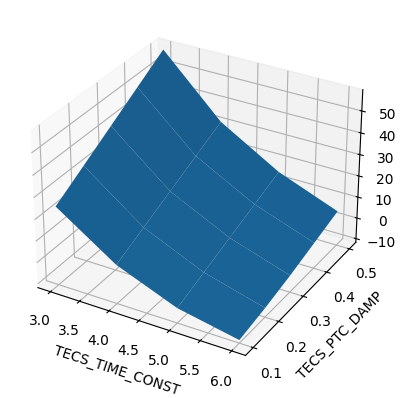

In [32]:
import numpy as np

V_l_dot_flat = V_l_dot.subs({
    k_i: 0.3,
    k_td: 0.5,
    x_intthrstar: 0,
    x_ipitchstar: 0
    })

def max_v(k_tc_val, k_pd_val):
    X, Y = np.meshgrid(np.arange(10,30,1), np.arange(-10,10,1))
    V = ufuncify((h_star, v_star), V_l_dot_flat.subs({k_tc: k_tc_val, k_pd: k_pd_val}))
    print(V)
    return np.max(np.max(V(X,Y)))

max_v_vec = np.vectorize(max_v)
X, Y = np.meshgrid(np.arange(3,7,1), np.arange(0.1,0.6,0.1))
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, max_v_vec(X, Y))
ax.set(xlabel='TECS_TIME_CONST', ylabel='TECS_PTC_DAMP', zlabel='Z')

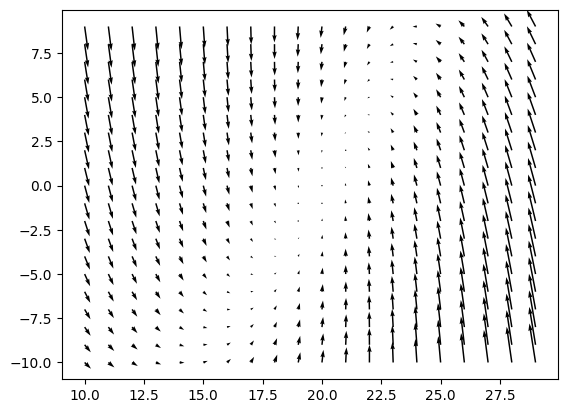

In [33]:
controller_gains = {
    k_pd: 0.5,
    k_i: 0.3,
    k_tc: 3,
    k_td: 0.5,
}
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2]
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2_flat]
X, Y = np.meshgrid(np.arange(10,30,1), np.arange(-10,10,1))
uxy = ufuncify((v_flat, h_flat), system_2_flat[0])
vxy = ufuncify((v_flat, h_flat), system_2_flat[1])
plt.figure()
plt.quiver(X, Y, uxy(X, Y), vxy(X, Y))

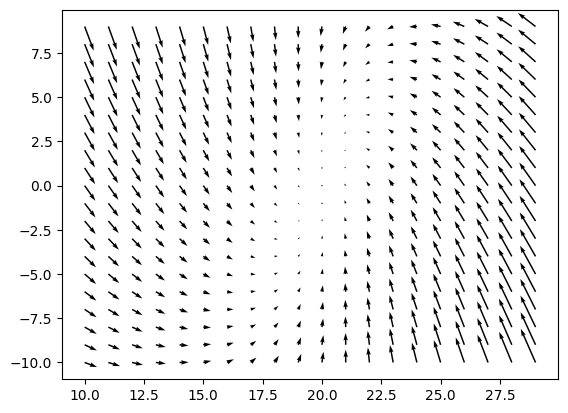

In [34]:
controller_gains = {
    k_pd: 0.1,
    k_i: 0.3,
    k_tc: 6,
    k_td: 0.5,
}
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2]
system_2_flat = [s.subs(num_values | fixed_states | controller_gains | map_fun_to_var) for s in system_2_flat]
X, Y = np.meshgrid(np.arange(10,30,1), np.arange(-10,10,1))
uxy = ufuncify((v_flat, h_flat), system_2_flat[0])
vxy = ufuncify((v_flat, h_flat), system_2_flat[1])
plt.figure()
plt.quiver(X, Y, uxy(X, Y), vxy(X, Y))